In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys
from types import SimpleNamespace

sys.path.insert(0,'../..')
%matplotlib inline

/Users/d3sm0/.virtualenvs/ntsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from ntsa.utils.data_utils import load_data
from ntsa.dataset import build_train_test_datasets

In [3]:
from ntsa.utils.misc import get_config
from ntsa.models.model import DARNN
from ntsa.train import Trainer
from ntsa.models.blocks import InputAttention
from ntsa.utils import Logger

In [4]:
data = load_data('../../data/benchmark/sm1_2010.csv')

In [5]:
features = data.columns.tolist()[1:]

In [6]:
data.head()

,temperature_comedor_sensor,temperature_habitacion_sensor,weather_temperature,co2_comedor_sensor,co2_habitacion_sensor,humedad_comedor_sensor,humedad_habitacion_sensor,lighting_comedor_sensor,lighting_habitacion_sensor,precipitacion,meteo_exterior_crepusculo,meteo_exterior_viento,meteo_exterior_sol_oest,meteo_exterior_sol_est,meteo_exterior_sol_sud,meteo_exterior_piranometro,temperature_exterior_sensor,humedad_exterior_sensor,day_of_week
date,,,,,,,,,,,,,,,,,,,
2012-03-13,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,18.1150,48.3750,2.0
2012-03-13,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,18.4147,47.8080,2.0
2012-03-13,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,18.8533,47.4320,2.0
2012-03-13,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,19.2907,47.0240,2.0
2012-03-13,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,19.7400,45.4743,2.0


In [55]:
#path = "../logs/darnn/ntsa-2019-01-03-11-10-46" # no kaf
path = "../../logs/darnn/ntsa-2019-01-03-11-11-41"

In [56]:
config = Logger.load(path=path)

In [57]:
config = SimpleNamespace(**config)

In [58]:
tr, ts, _ = build_train_test_datasets(data, config)

In [59]:
model = DARNN(tr.shape, config=config, encoder_attn='input', decoder_attn=None)

In [60]:
tf.reset_default_graph()

In [61]:
trainer = Trainer(model, path='lol')

INFO:tensorflow:Built model with scope darnn


In [62]:
trainer.init_sess()

In [63]:
trainer.restore(path)

INFO:tensorflow:Restoring parameters from ../../logs/darnn/ntsa-2019-01-03-11-11-41/model/-94606


In [64]:
model.vars

[<tf.Variable 'darnn/encoder/alpha:0' shape=(1, 18, 20) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/memory/kernel:0' shape=(74, 1) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/gates/kernel:0' shape=(82, 128) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/candidate/kernel:0' shape=(82, 64) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/gates/kernel:0' shape=(65, 128) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/candidate/kernel:0' shape=(65, 64) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/fc/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/fc/bias:0' 

In [65]:
# get only encoder vars
encoder = [v for v in model.vars if 'encoder' in v.name]

In [66]:
alpha_kaf = trainer.sess.run(encoder[0])

In [67]:
def kaf(x, alpha):
    d = np.linspace(-1., 1., 20)
    gamma = .5 / (2 * (d[-1] - d[0])**2)
    x = np.expand_dims(x, axis=-1)
    d = d.reshape((1,1,-1))
    assert x.ndim == d.ndim
    K = np.exp(-gamma * (x-d)**2)
    return (alpha * K).sum(axis=-1)


In [68]:
x = np.linspace(-5.,5., 18)

In [69]:
act = kaf(x[None, :],alpha_kaf)

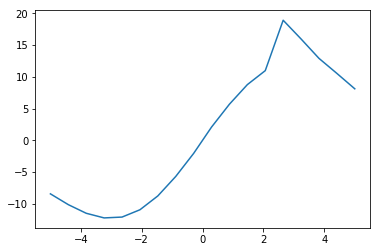

In [70]:
plt.plot(x.flatten(), act.flatten())

In [71]:
tf.trainable_variables()

[<tf.Variable 'darnn/encoder/alpha:0' shape=(1, 18, 20) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/memory/kernel:0' shape=(74, 1) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/gates/kernel:0' shape=(82, 128) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/candidate/kernel:0' shape=(82, 64) dtype=float32_ref>,
 <tf.Variable 'darnn/encoder/gru_cell_1/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/gates/kernel:0' shape=(65, 128) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/candidate/kernel:0' shape=(65, 64) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/gru_cell_1/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/fc/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'darnn/decoder/fc/bias:0' 

In [72]:
attn  = InputAttention(output_shape=1, memory=model.x, use_kaf=True)

In [73]:
### Ops restoring
s = tf.zeros(shape=[128, 64], dtype=tf.float32)

x_tilde, s_tilde, _ = attn.apply(model.x[:, 0,:] ,s, t=0)

update_alpha= tf.assign(attn._k.alpha,encoder[0])
update_memory = tf.assign(attn._memory_layer.trainable_variables[0],encoder[1])

cell = tf.nn.rnn_cell.GRUCell(num_units=64, reuse=tf.AUTO_REUSE)
y, s = cell(x_tilde, s_tilde)
update_gru = tf.group(*[tf.assign(t,s) for t,s in zip(cell.trainable_variables, encoder[2:])])

_ = trainer.sess.run([update_gru, 
                      update_memory,
                      update_alpha
                 ])

In [74]:
batch = tr.next()

In [75]:
x = batch[0]['x']

In [76]:
xs = []
alphas = []
for t in range(x.shape[1]):
    x_tilde, s_tilde, w = attn.apply(model.x[:, t, :], s,t=t)
    alphas.append(w)
    _, s = cell(x_tilde, s_tilde)
    xs.append((x_tilde, model.x[:, t, :]))

In [77]:
alphas,out = trainer.sess.run([alphas,xs], feed_dict={model.x:x})

In [78]:
x_tilde, x = np.split(np.array(out),2, axis=1)
x_tilde = np.squeeze(x_tilde, axis=1).swapaxes(1,0).reshape((-1, x_tilde.shape[-1]))
x = np.squeeze(x, axis=1).swapaxes(1,0).reshape((-1, x.shape[-1]))

In [79]:
alphas = np.array(alphas)
alphas = alphas.swapaxes(1,0).reshape((-1, alphas.shape[-1]))

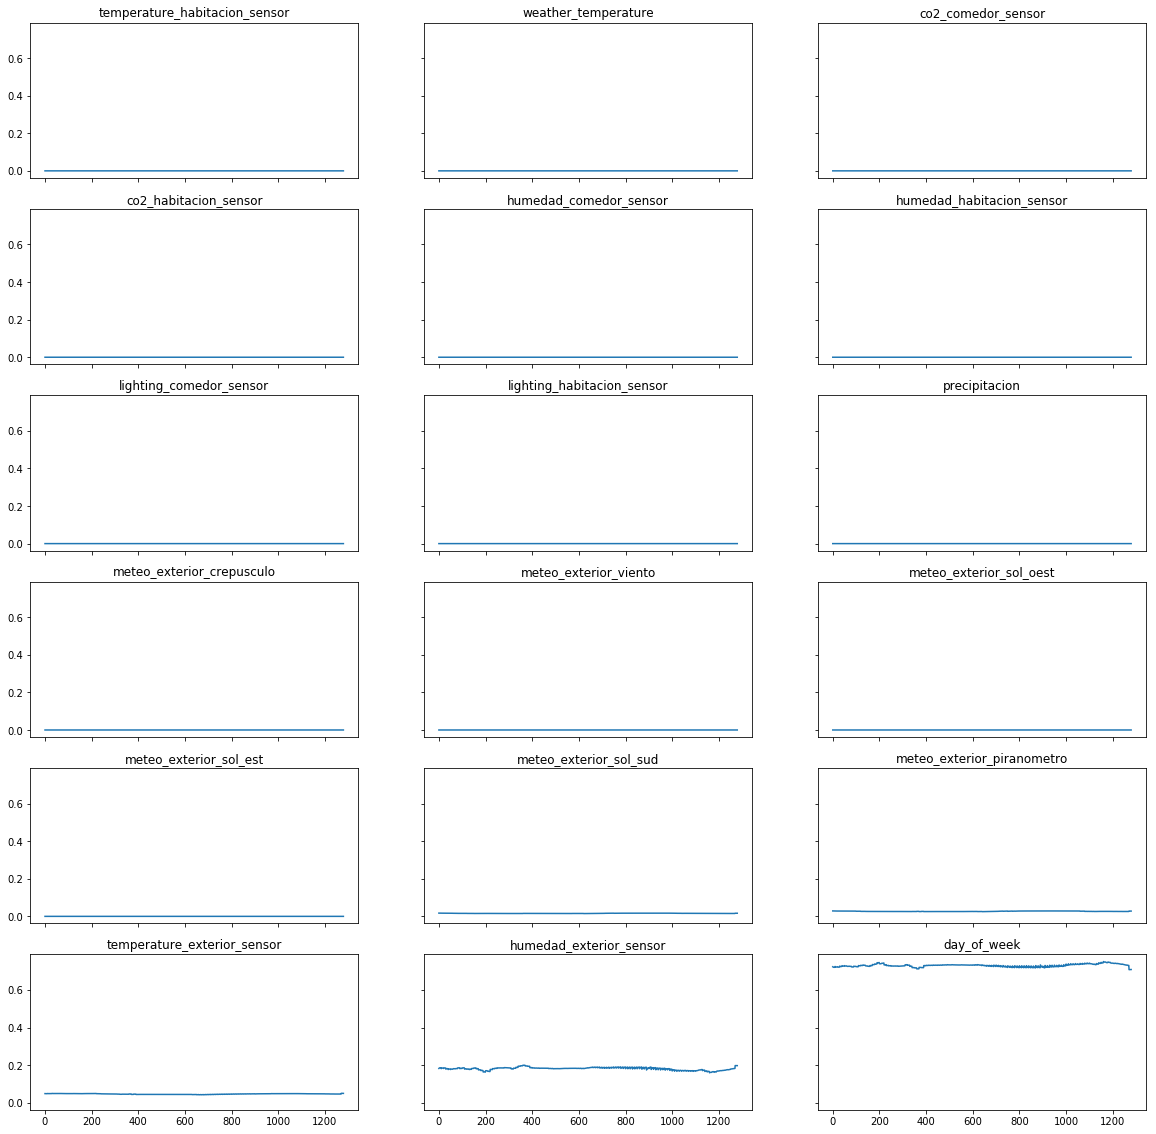

In [80]:
# x_axis time
# y_axis value
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(alphas.shape[-1]), ax.flatten()):
    a.plot(alphas[:, idx])
    a.set_title(features[idx])


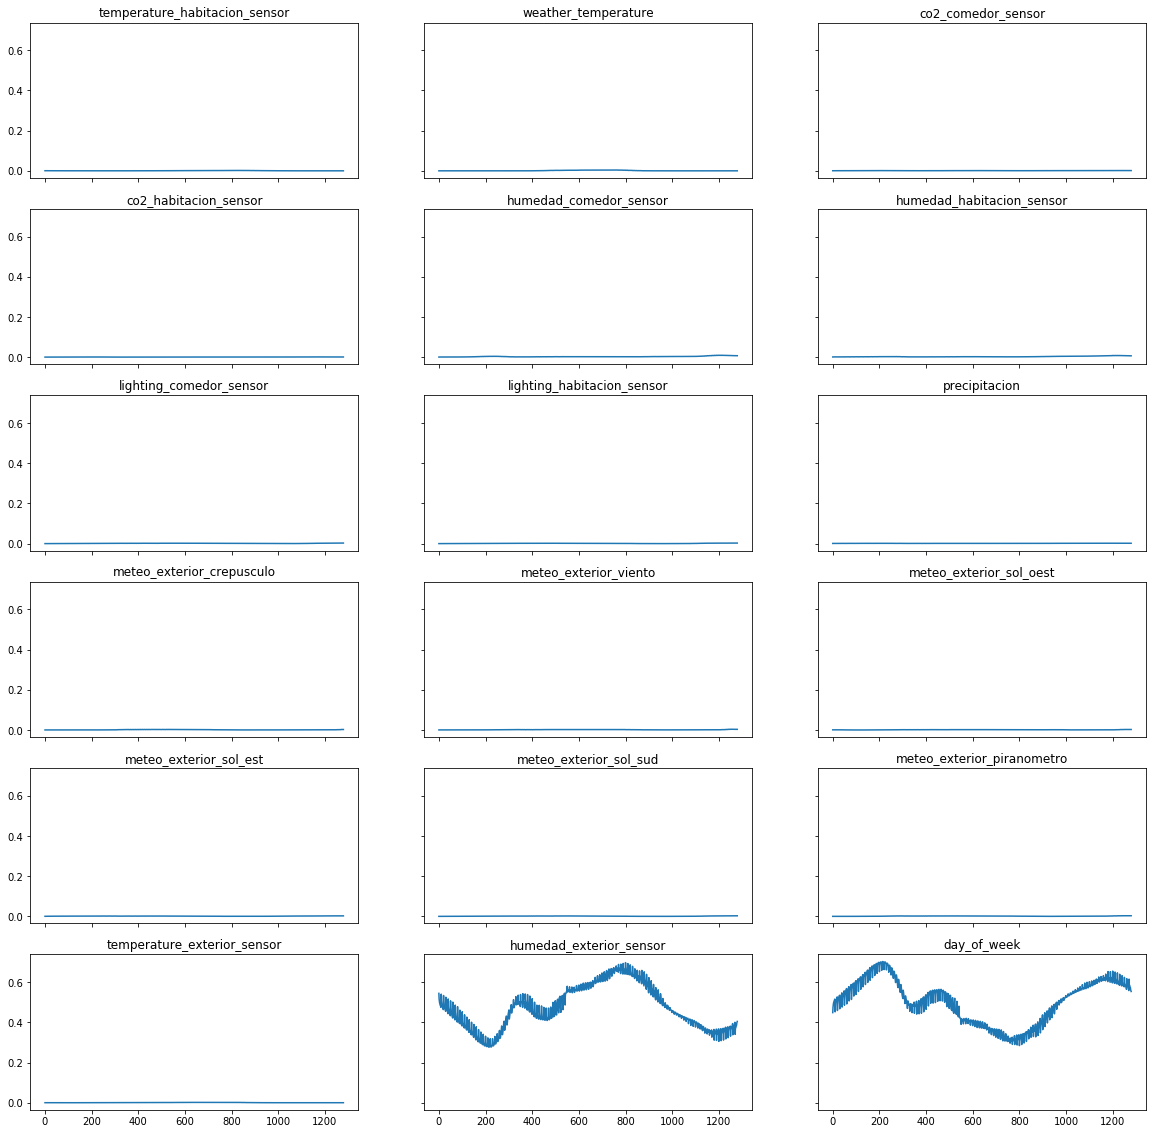

In [32]:
# x_axis time
# y_axis value
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(alphas.shape[-1]), ax.flatten()):
    a.plot(alphas[:, idx])
    a.set_title(features[idx])


#### OLD STUFF TO DELETE

## Input attention

As in [DARNN](https://arxiv.org/pdf/1704.02971.pdf) the input attention is designed to focus on early stage stimulus in the inpt process. Given a cell hidden state $h_{t-1}$ and the series features $x_{t-1}$, attention is computed as:

$$e_t^k = W(h_{t-1} + x^k) + b$$

Notice that this attention mechanism is built considering the whole batch.

$$\alpha_t^k = softmax(e_t^k)$$

The candidate output, $\widetilde{x}$ it's given by:

$$\widetilde{x_t} = \alpha_t \odot x_t $$

In [ ]:
path="../tf/rnn/woc-2018-09-26-10-34-04"

In [ ]:
config = Logger.get_config(path)

In [ ]:
df = pd.read_pickle('../data/sml.pkl')

In [ ]:
features = df.columns.tolist()
features

In [ ]:
x, index, stats = make_features(df, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [ ]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=False)

In [ ]:
it = dataset.__iter__()

In [ ]:
feeds, dates = next(it)
dataset._idx

In [ ]:
tf.reset_default_graph()

In [ ]:
model = RNN(dataset.shape, config=config)

In [ ]:
trainer = Trainer(model, config=config, path=path)

In [ ]:
trainer.init_sess()

In [ ]:
trainer.restore(path=path)

In [ ]:
sess =trainer.sess

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
tf.trainable_variables()

In [ ]:
h = model.x

In [ ]:
attn = InputAttention(output_shape=1, memory=h, name='rnn/encoder/input_attention', use_bias=True)

In [ ]:
state = tf.zeros(shape=(8, config.encoder), dtype=tf.float32)

In [ ]:
t = 0 

In [ ]:
tf.trainable_variables()

In [ ]:
alpha = sess.run(tf.trainable_variables()[0])

In [ ]:
alpha = np.squeeze(alpha)

In [ ]:
alpha[:,0]

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)
for k,a in zip(range(18), ax.flatten()):
    a.plot(np.linspace(-2, 2,20),alpha[:, k])
    a.set_title(features[k])

In [ ]:
x_tilde = attn.apply(h[:, t,:], state)

In [ ]:
feed_dict = trainer._get_dict(feeds)

### First timestep, first batch of random day

In [ ]:
features.pop(0)

In [ ]:
attn._act.alpha = tf.trainable_variables()[0]

In [ ]:
x_tilde = trainer.sess.run(x_tilde, feed_dict)

In [ ]:
x_tilde = x_tilde.mean(axis=0).reshape((1,-1))

In [ ]:
# features importance for each a single sequence at time 0
df = pd.DataFrame(x_tilde, columns=features)

In [ ]:
mif = df[df>0].fillna(0)
mif.mean(axis=0).sort_values(ascending=False)

In [ ]:
lif = df[df<0.0].fillna(0)
lif.mean(axis=0).sort_values(ascending=True)

### Single batch over time steps

In [ ]:
cell = tf.contrib.rnn.GRUBlockCellV2(num_units=config.encoder, reuse=tf.AUTO_REUSE, name='rnn/encoder/gru_cell')

In [ ]:
from utils.tf_utils import kaf

In [ ]:
states = []
c_xs = []
state = tf.zeros(shape=(8, config.encoder), dtype=tf.float32)
weights = []
for t in range(config.seq_len):
    c_x = attn.apply(h[:, t, :], state)
    w = c_x/h[:,t,:]
    weights.append(w)
    _, state = cell(c_x, state)
    states.append(state)
    c_xs.append(c_x)

In [ ]:
c_xs = trainer.sess.run(c_xs, feed_dict)

In [ ]:
D =  np.linspace(-1.,1., 20).reshape((-1,1))
gamma = .5 / np.square(2* (D[-1] - D[0]))
K = np.exp(-gamma * (D - D.T)**2)
init_alpha = np.linalg.solve(K + 1e-1*np.eye(20), D)

In [ ]:
init_alpha = np.tile(init_alpha.reshape(-1,20), (alpha.shape[0],1))

In [ ]:
def kaf_np(x, d, gamma):
    kaf = np.exp(-gamma * np.square(x - d))
    return kaf

In [ ]:
plt.plot(np.arange(-5,5,1), kaf_np(np.arange(-5,5, 1).reshape(1,10, 1), D.reshape((1,1, -1)), gamma).sum(axis=-1).flatten())

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)
# red init values and green trained values
k = kaf_np(np.arange(-5,5,1).reshape(1,10,1), D.reshape(1,1,-1), gamma)
for idx,a in zip(range(alpha.shape[0]), ax.flatten()):
    out_0 = (k * init_alpha[np.newaxis, idx, :]).sum(axis=-1).flatten()
    out = (k * alpha[np.newaxis,idx,:]).sum(axis=-1).flatten()
    a.plot(np.arange(-5,5,1),out_0, 'r')
    a.plot(np.arange(-5,5,1),out, '-g')
    a.set_xlim(left=-5, right=5)
    a.set_title(features[idx])

In [ ]:
fig.savefig('alpha_kaf.png')

In [ ]:
ws = sess.run(weights,feed_dict)

In [ ]:
ws = np.array(ws)

In [ ]:
c_xs=np.array(c_xs)

In [ ]:
avg_ws = ws.mean(axis=1)

In [ ]:
import seaborn as sns

In [ ]:
plt.plot(avg_ws.cumsum(axis=1).T)
plt.title('Cumulative dist of activation')

In [ ]:
avg_ws[0,:]

In [ ]:
sns.distplot(avg_ws[0,:].flatten())a

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(20,20), sharex=True, sharey=True)

for t,a in zip(range(avg_ws.shape[0]), ax.flatten()):
    a.plot(np.linspace(0,1,18),avg_ws[t, :])
    #a.plot(avg_ws[t,:].cumsum())
    #a.hist(avg_ws_no_kaf[t,: ], density=True)
    a.set_title(str(t))

In [ ]:
fig.savefig('ws_per_time.png')

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_ws.shape[-1]), ax.flatten()):
    a.plot(avg_ws[:, idx])
    a.plot(avg_ws_no_kaf[:, idx])
    a.set_title(features[idx])


In [ ]:
fig.savefig('avg_ws.png')

In [ ]:
avg_c = c_xs.mean(axis=1)

In [ ]:
avg_c = (avg_c - avg_c.mean(axis=0))/ (avg_c.std(axis=0) + 1e-5)

In [ ]:
x_true = feed_dict[model.x]

In [ ]:
avg_c_true = x_true.mean(axis=0)

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_c.shape[-1]), ax.flatten()):
    a.plot(avg_c[:, idx])
    a.plot(avg_c_true[:, idx])
    a.set_title(features[idx])


In [ ]:
fig.savefig('input_attn_avg_batch_kaf.png')

In [ ]:
avg_b = c_xs.mean(axis=0)

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_b.shape[-1]), ax.flatten()):
    a.plot(avg_b[:, idx])
    a.set_title(features[idx])


In [ ]:
fig.savefig('input_attn_avg_time')

In [ ]:
full_series = c_xs.reshape((-1,len(features)))

In [ ]:
t = (full_series - full_series.mean(axis=0)) / full_series.std(axis=0)

In [ ]:
full_series_true = x_true.reshape((-1,len(features)))

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(full_series.shape[-1]), ax.flatten()):
    a.plot(t[:, idx])
    a.plot(full_series_true[:, idx])
    a.set_title(features[idx])

In [ ]:
fig.savefig('input_attn_full.png')

In [ ]:
df_= pd.read_csv('../tf/rnn/woc-2018-09-25-20-16-52/report_train.csv', index_col=0)

In [ ]:
df  = pd.read_csv(path + '/report_train.csv', index_col=0)

In [ ]:
df  = pd.read_csv(path + '/report_train.csv', index_col=0)

In [ ]:
df.smape.plot()
df_.smape.plot()
plt.legend(['kaf', 'no_kaf'])
plt.savefig('loss.png')

In [ ]:
path